# Fully-Connected Neural Networks and Dropout

In [ ]:
student_id =  401201381
student_name = "Pouria Dadkhah"

print("your student id:", student_id)
print("your name:", student_name)

your student id: 401201381
your name: Pouria Dadkhah


## Setup Code
First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Deep Learning/DL_HW2/Q1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['libs', '__pycache__', 'fully_connected_networks.py', 'fully_connected_networks.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

fully_connected_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'fully_connected_networks.py')
fully_connected_networks_edit_time = time.ctime(os.path.getmtime(fully_connected_networks_path))
print('fully_connected_networks.py last edited on %s' % fully_connected_networks_edit_time)

fully_connected_networks.py last edited on Tue Nov 14 08:41:16 2023


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import libs
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from libs import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset. The utility function `libs.data.preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

100%|██████████| 170498071/170498071 [00:04<00:00, 42547306.17it/s]


Extracting ./cifar-10-python.tar.gz to .


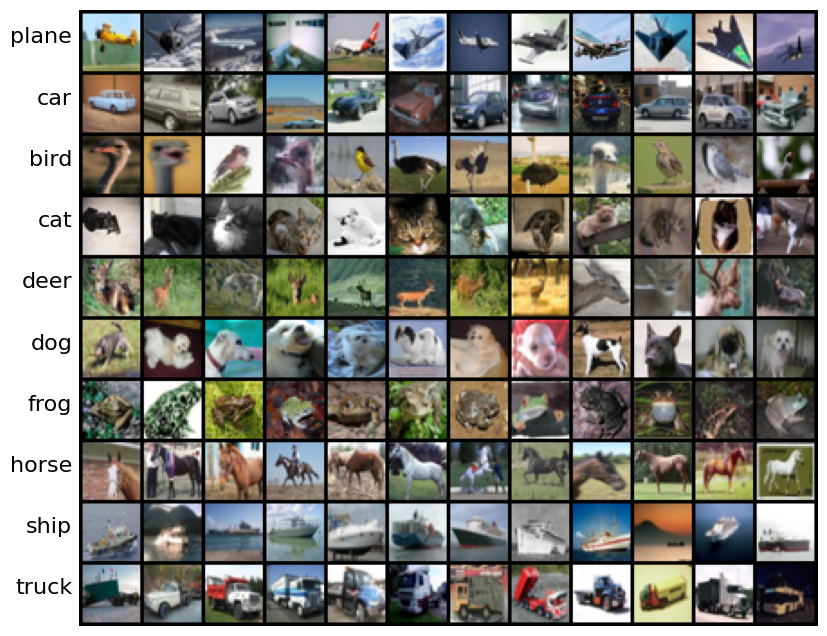

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [ ]:
import libs

reset_seed(0)

# If you are using gpu, you can set cuda to true
data_dict = libs.data.preprocess_cifar10(cuda=False, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Fully-connected neural networks

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer as a tool to more efficiently optimize deep networks.
  

# Linear layer

For each layer we implement, we will define a class with two static methods `forward` and `backward`. The class structure is currently provided in `fully_connected_layers.py`, you will be implementing both the `forward` and `backward` methods.

## Linear layer: forward
Implement the `Linear.forward` function in `fully_connected_layers.py`. Once you are done you can test your implementaion by running the next cell. You should see errors less than `1e-7`.

In [ ]:
from fully_connected_networks import Linear

# Test the Linear.forward function
num_inputs = 2
input_shape = torch.tensor((4, 5, 6))
output_dim = 3

input_size = num_inputs * torch.prod(input_shape)
weight_size = output_dim * torch.prod(input_shape)

x = torch.linspace(-0.1, 0.5, steps=input_size, dtype=torch.float64, device=device)
w = torch.linspace(-0.2, 0.3, steps=weight_size, dtype=torch.float64, device=device)
b = torch.linspace(-0.3, 0.1, steps=output_dim, dtype=torch.float64, device=device)
x = x.reshape(num_inputs, *input_shape)
w = w.reshape(torch.prod(input_shape), output_dim)

out, _ = Linear.forward(x, w, b)
correct_out = torch.tensor([[1.49834984, 1.70660150, 1.91485316],
                            [3.25553226, 3.51413301, 3.77273372]]
                            ).double().to(device)

print('Testing Linear.forward function:')
print('difference: ', libs.grad.rel_error(out, correct_out))

Testing Linear.forward function:
difference:  3.683042917976506e-08


## Linear layer: backward
Now implement the `Linear.backward` function and test your implementation using numeric gradient checking.

Run the following to test your implementation of `Linear.backward`. You should see errors less than `1e-7`.

In [ ]:
from fully_connected_networks import Linear

# Test the Linear.backward function
reset_seed(0)
x = torch.randn(10, 2, 3, dtype=torch.float64, device=device)
w = torch.randn(6, 5, dtype=torch.float64, device=device)
b = torch.randn(5, dtype=torch.float64, device=device)
dout = torch.randn(10, 5, dtype=torch.float64, device=device)

dx_num = libs.grad.compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = libs.grad.compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = libs.grad.compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', libs.grad.rel_error(dx_num, dx))
print('dw error: ', libs.grad.rel_error(dw_num, dw))
print('db error: ', libs.grad.rel_error(db_num, db))

Testing Linear.backward function:
dx error:  5.221943563709987e-10
dw error:  3.498388787266994e-10
db error:  5.373171200544344e-10


# ReLU activation

We will now implement the ReLU nonlinearity. As above, we will define a class with two empty static methods, and implement them in upcoming cells. The class structure can be found in `fully_connected_networks.py`

## ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `ReLU.forward` function. You **should not** change the input tensor with an in-place operation.

Run the following to test your implementation of the ReLU forward pass. Your errors should be less than `1e-7`.

In [ ]:
from fully_connected_networks import ReLU

reset_seed(0)
x = torch.linspace(-0.5, 0.5, steps=12, dtype=torch.float64, device=device)
x = x.reshape(3, 4)

out, _ = ReLU.forward(x)
correct_out = torch.tensor([[ 0.,          0.,          0.,          0.,        ],
                            [ 0.,          0.,          0.04545455,  0.13636364,],
                            [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]],
                            dtype=torch.float64,
                            device=device)

# Compare your output with ours. The error should be on the order of e-9
print('Testing ReLU.forward function:')
print('difference: ', libs.grad.rel_error(out, correct_out))

Testing ReLU.forward function:
difference:  4.5454545613554664e-09


## ReLU activation: backward
Now implement the backward pass for the ReLU activation function.

Again, you should not change the input tensor with an in-place operation.

Run the following to test your implementation of `ReLU.backward`. Your errors should be less than `1e-8`.

In [ ]:
from fully_connected_networks import ReLU

reset_seed(0)
x = torch.randn(10, 10, dtype=torch.float64, device=device)
dout = torch.randn(*x.shape, dtype=torch.float64, device=device)

dx_num = libs.grad.compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)

_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)

# The error should be on the order of e-10
print('Testing ReLU.backward function:')
print('dx error: ', libs.grad.rel_error(dx_num, dx))

Testing ReLU.backward function:
dx error:  2.6317796097761553e-10


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, linear layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define a convenience layer.

This also shows how our layer abstraction allows us to implement new layers by composing existing layer implementations. This is a powerful mechanism for structuring deep learning code in a modular fashion.

For now take a look at the `forward` and `backward` functions in `Linear_ReLU`, and run the following to numerically gradient check the backward pass.

Run the following to test the implementation of the `Linear_ReLU` layer using numeric gradient checking. You should see errors less than `1e-8`

In [ ]:
from fully_connected_networks import Linear_ReLU

reset_seed(0)
x = torch.randn(2, 3, 4, dtype=torch.float64, device=device)
w = torch.randn(12, 10, dtype=torch.float64, device=device)
b = torch.randn(10, dtype=torch.float64, device=device)
dout = torch.randn(2, 10, dtype=torch.float64, device=device)

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = libs.grad.compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = libs.grad.compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = libs.grad.compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ', libs.grad.rel_error(dx_num, dx))
print('dw error: ', libs.grad.rel_error(dw_num, dw))
print('db error: ', libs.grad.rel_error(db_num, db))

Testing Linear_ReLU.forward and Linear_ReLU.backward:
dx error:  1.210759699545244e-09
dw error:  7.462948482161807e-10
db error:  8.915028842081707e-10


# Loss layers: Softmax
We will now implement the Softmax. As above, we will define a function and you can be found in `fully_connected_networks.py`


Run the following to perform numeric gradient checking on the loss function. You should see error less than `1e-6` for softmax_loss.

In [ ]:
from fully_connected_networks import softmax_loss

reset_seed(0)
num_classes, num_inputs = 10, 50
x = 0.001 * torch.randn(num_inputs, num_classes, dtype=torch.float64, device=device)
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device=device)

dx_num = libs.grad.compute_numeric_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss.item())
print('dx error: ', libs.grad.rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.3026286102347924
dx error:  1.0417990899757076e-07


# Two-layer network

Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API.

Once you have finished implementing the forward and backward passes of your two-layer net, run the following to test your implementation:

In [ ]:
from fully_connected_networks import TwoLayerNet, softmax_loss

reset_seed(0)
N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, dtype=torch.float64, device=device)
y = torch.randint(C, size=(N,), dtype=torch.int64, device=device)

std = 1e-3
model = TwoLayerNet(
          input_dim=D,
          hidden_dim=H,
          num_classes=C,
          weight_scale=std,
          dtype=torch.float64,
          device=device
        )

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.7, 0.3, steps=D * H, dtype=torch.float64, device=device).reshape(D, H)
model.params['b1'] = torch.linspace(-0.1, 0.9, steps=H, dtype=torch.float64, device=device)
model.params['W2'] = torch.linspace(-0.3, 0.4, steps=H * C, dtype=torch.float64, device=device).reshape(H, C)
model.params['b2'] = torch.linspace(-0.9, 0.1, steps=C, dtype=torch.float64, device=device)
X = torch.linspace(-5.5, 4.5, steps=N * D, dtype=torch.float64, device=device).reshape(D, N).t()
scores = model.loss(X)
correct_scores = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    dtype=torch.float64, device=device)
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556

print(loss)
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 49.719461034881775
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = libs.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, libs.grad.rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
tensor(3.4702, device='cuda:0', dtype=torch.float64)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.57e-07
W2 relative error: 1.60e-09
b1 relative error: 1.01e-06
b2 relative error: 4.63e-09
Running numeric gradient check with reg =  0.7
W1 relative error: 2.70e-08
W2 relative error: 9.86e-09
b1 relative error: 2.28e-06
b2 relative error: 2.90e-08


# Solver

for this assignment we have split the logic for training models into a separate class. Read through `help(Solver)` to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [ ]:
print(help(Solver))

Help on class Solver in module libs.solver:

class Solver(builtins.object)
 |  Solver(model, data, **kwargs)
 |  
 |  A Solver encapsulates all the logic necessary for training classification
 |  models. The Solver performs stochastic gradient descent using different
 |  update rules.
 |  The solver accepts both training and validation data and labels so it can
 |  periodically check classification accuracy on both training and validation
 |  data to watch out for overfitting.
 |  To train a model, you will first construct a Solver instance, passing the
 |  model, dataset, and various options (learning rate, batch size, etc) to the
 |  constructor. You will then call the train() method to run the optimization
 |  procedure and train the model.
 |  After the train() method returns, model.params will contain the parameters
 |  that performed best on the validation set over the course of training.
 |  In addition, the instance variable solver.loss_history will contain a list
 |  of all lo

Use the Solver classe to create a solver instance that trains a TwoLayerNet to achieve at least 50% performance on the validation set.

**Implement** `create_solver_instance` in `fully_connected_networks.py` to return a solver instance. Make sure to initialize the Solver instance with the input device.

In [ ]:
from fully_connected_networks import create_solver_instance

reset_seed(10)
# Create a solver instance that achieves 50% performance on the validation set
solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device=device)

solver.train()


(Time 0.02 sec; Iteration 1 / 12000) loss: 2.302579
(Epoch 0 / 30) train acc: 0.117000; val_acc: 0.131400
(Time 0.98 sec; Iteration 101 / 12000) loss: 2.315374
(Time 1.52 sec; Iteration 201 / 12000) loss: 2.106272
(Time 2.05 sec; Iteration 301 / 12000) loss: 2.084213
(Epoch 1 / 30) train acc: 0.278000; val_acc: 0.266500
(Time 2.76 sec; Iteration 401 / 12000) loss: 2.020326
(Time 3.31 sec; Iteration 501 / 12000) loss: 1.981458
(Time 3.84 sec; Iteration 601 / 12000) loss: 1.990092
(Time 4.37 sec; Iteration 701 / 12000) loss: 2.010112
(Epoch 2 / 30) train acc: 0.385000; val_acc: 0.358100
(Time 5.07 sec; Iteration 801 / 12000) loss: 1.932785
(Time 5.60 sec; Iteration 901 / 12000) loss: 1.833013
(Time 6.15 sec; Iteration 1001 / 12000) loss: 1.676719
(Time 6.68 sec; Iteration 1101 / 12000) loss: 1.726228
(Epoch 3 / 30) train acc: 0.435000; val_acc: 0.410100
(Time 7.39 sec; Iteration 1201 / 12000) loss: 1.568806
(Time 7.93 sec; Iteration 1301 / 12000) loss: 1.708110
(Time 8.46 sec; Iteration 

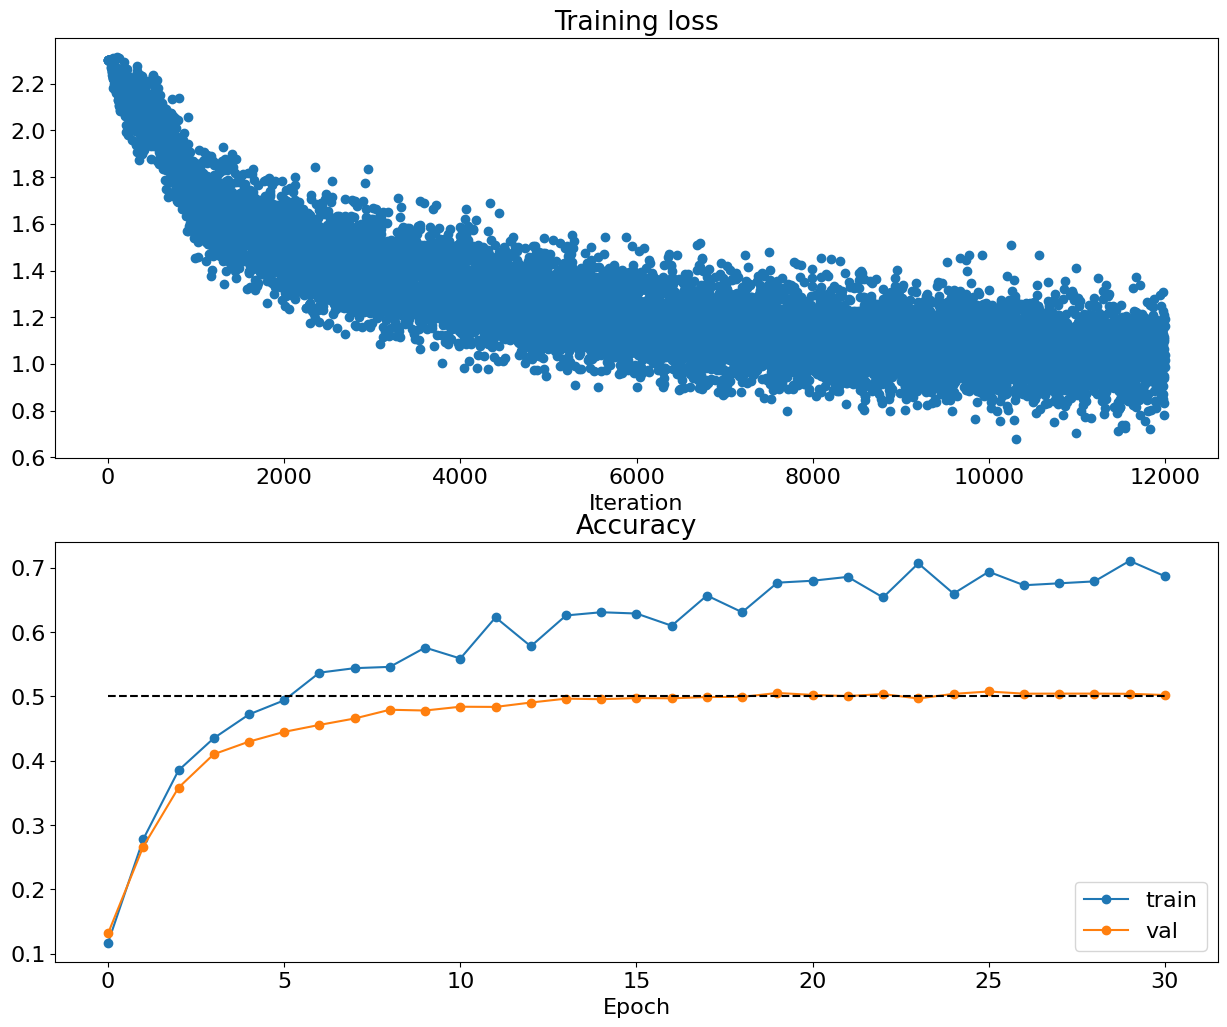

In [ ]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

If you're happy with the model's perfromance, run the following cell to save it.

We will also reload the model and run it on validation to verify it's the right weights.

In [ ]:
import os

local_path = '.'
path = os.path.join(local_path, 'best_two_layer_net.pth')
solver.model.save(path)

# Create a new instance
from fully_connected_networks import create_solver_instance
reset_seed(0)

solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device=device)

# Load model
solver.model.load(path, dtype=torch.float64, device=device)

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_val, solver.y_val)
print(f"Saved model's accuracy on validation is {accuracy}")


Saved in ./best_two_layer_net.pth
load checkpoint file: ./best_two_layer_net.pth
Saved model's accuracy on validation is 0.5076999664306641


# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in `fully_connected_networks.py`. Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout; we will add this feature soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors less than `1e-6`, except for the check on `W1` and `W2` with `reg=0` where your errors should be less than `1e-5`.

In [ ]:
from fully_connected_networks import FullyConnectedNet

reset_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, dtype=torch.float64, device=device)
y = torch.randint(C, size=(N,), dtype=torch.int64, device=device)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=torch.float64,
        device=device
  )

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = libs.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, libs.grad.rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3053575717037686
W1 relative error: 5.33e-08
W2 relative error: 7.54e-08
W3 relative error: 5.21e-08
b1 relative error: 1.28e-07
b2 relative error: 2.22e-08
b3 relative error: 2.13e-09
Running check with reg =  3.14
Initial loss:  7.29369633719099
W1 relative error: 7.52e-09
W2 relative error: 8.39e-09
W3 relative error: 9.56e-09
b1 relative error: 1.10e-07
b2 relative error: 3.19e-08
b3 relative error: 6.23e-09


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Time 0.00 sec; Iteration 1 / 40) loss: 2.473269
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.107100
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.124200
(Epoch 2 / 20) train acc: 0.480000; val_acc: 0.137900
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.139500
(Epoch 4 / 20) train acc: 0.620000; val_acc: 0.155800
(Epoch 5 / 20) train acc: 0.780000; val_acc: 0.158100
(Time 0.47 sec; Iteration 11 / 40) loss: 1.154776
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.166800
(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.172100
(Epoch 8 / 20) train acc: 0.880000; val_acc: 0.172000
(Epoch 9 / 20) train acc: 0.900000; val_acc: 0.169700
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.170100
(Time 0.85 sec; Iteration 21 / 40) loss: 0.575423
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.181900
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.179900
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.181100
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.183700
(Epoch 15 / 20) train acc: 0.980000;

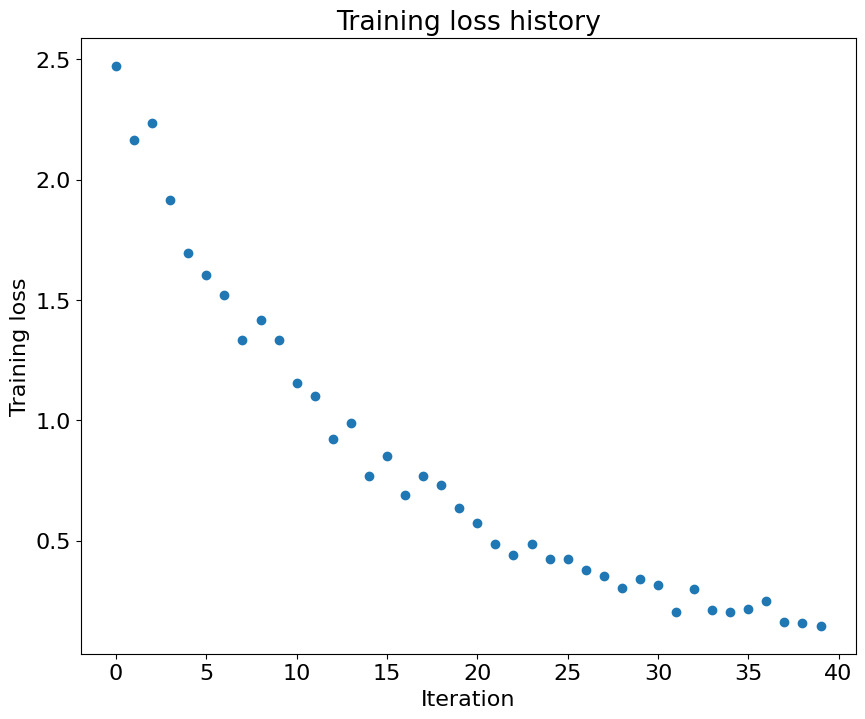

In [ ]:
from fully_connected_networks import FullyConnectedNet, get_three_layer_network_params


reset_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_three_layer_network_params()

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=torch.float32, device=device)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device=device,
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy.

(Time 0.00 sec; Iteration 1 / 40) loss: 2.262105
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.101300
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.104900
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.127600
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.139900
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.169100
(Epoch 5 / 20) train acc: 0.640000; val_acc: 0.159200
(Time 0.64 sec; Iteration 11 / 40) loss: 1.240487
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.180200
(Epoch 7 / 20) train acc: 0.560000; val_acc: 0.161600
(Epoch 8 / 20) train acc: 0.760000; val_acc: 0.164300
(Epoch 9 / 20) train acc: 0.700000; val_acc: 0.161800
(Epoch 10 / 20) train acc: 0.880000; val_acc: 0.183800
(Time 1.09 sec; Iteration 21 / 40) loss: 0.684833
(Epoch 11 / 20) train acc: 0.840000; val_acc: 0.186300
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.185700
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.188400
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.188700
(Epoch 15 / 20) train acc: 0.980000;

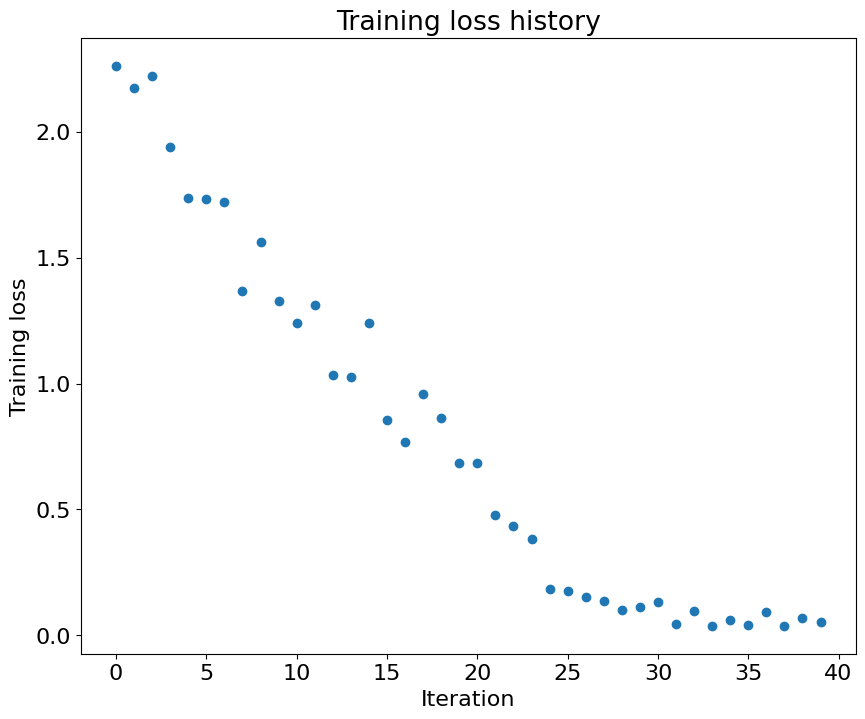

In [ ]:
from fully_connected_networks import FullyConnectedNet, get_five_layer_network_params


reset_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}


# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_five_layer_network_params()

# Run models and solver with parameters
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=torch.float32, device=device)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device=device,
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

If you're satisfied with your model's performance, save the overfit model. Just a sanity check, we evaluate it one the training set again to verify that the saved weights have the correct performance.

In [ ]:
import os

local_path = '.'
path = os.path.join(local_path, 'best_overfit_five_layer_net.pth')
solver.model.save(path)


# Create a new instance  -- Note that hidden dims being different doesn't matter here.
model = FullyConnectedNet(hidden_dims=[100, ], dtype=torch.float32, device=device)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device=device,
         )


# Load model
solver.model.load(path, dtype=torch.float32, device=device)

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_train, solver.y_train)
print(f"Saved model's accuracy on small train is {accuracy}")


Saved in ./best_overfit_five_layer_net.pth
load checkpoint file: ./best_overfit_five_layer_net.pth
Saved model's accuracy on small train is 1.0


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

We will implement various first-order update rules that are commonly used
for training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:
```python
def update(w, dw, config=None):
Inputs:
  - w: A tensor giving the current weights.
  - dw: A tensor of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.
Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.
NOTE: For most update rules, the default learning rate will probably not
perform well; however the default values of the other hyperparameters should
work well for a variety of different problems.
For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
```
We provide the implementation of the SGD update rule for your reference in `fully_connected_networks.py`

Now **implement** the SGD+Momentum update rule using the same interface. Run the following to check your implementation of SGD+Momentum. You should see errors less than `1e-7`.



In [ ]:
from fully_connected_networks import sgd_momentum

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)
v = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = torch.tensor([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]],
   dtype=torch.float64, device=device)
expected_velocity = torch.tensor([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]],
   dtype=torch.float64, device=device)

# Should see relative errors around e-8 or less
print('next_w error: ', libs.grad.rel_error(next_w, expected_next_w))
print('velocity error: ', libs.grad.rel_error(expected_velocity, config['velocity']))

next_w error:  1.6802078709310813e-09
velocity error:  2.9254212825785614e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Time 0.07 sec; Iteration 1 / 200) loss: 2.302626
(Epoch 0 / 5) train acc: 0.097000; val_acc: 0.100700
(Epoch 1 / 5) train acc: 0.096000; val_acc: 0.100400
(Epoch 2 / 5) train acc: 0.134000; val_acc: 0.117600
(Epoch 3 / 5) train acc: 0.114000; val_acc: 0.100300
(Epoch 4 / 5) train acc: 0.095000; val_acc: 0.099400
(Epoch 5 / 5) train acc: 0.093000; val_acc: 0.092300

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302484
(Epoch 0 / 5) train acc: 0.071000; val_acc: 0.074100
(Epoch 1 / 5) train acc: 0.105000; val_acc: 0.099700
(Epoch 2 / 5) train acc: 0.154000; val_acc: 0.152000
(Epoch 3 / 5) train acc: 0.170000; val_acc: 0.163600
(Epoch 4 / 5) train acc: 0.263000; val_acc: 0.247000
(Epoch 5 / 5) train acc: 0.296000; val_acc: 0.265400



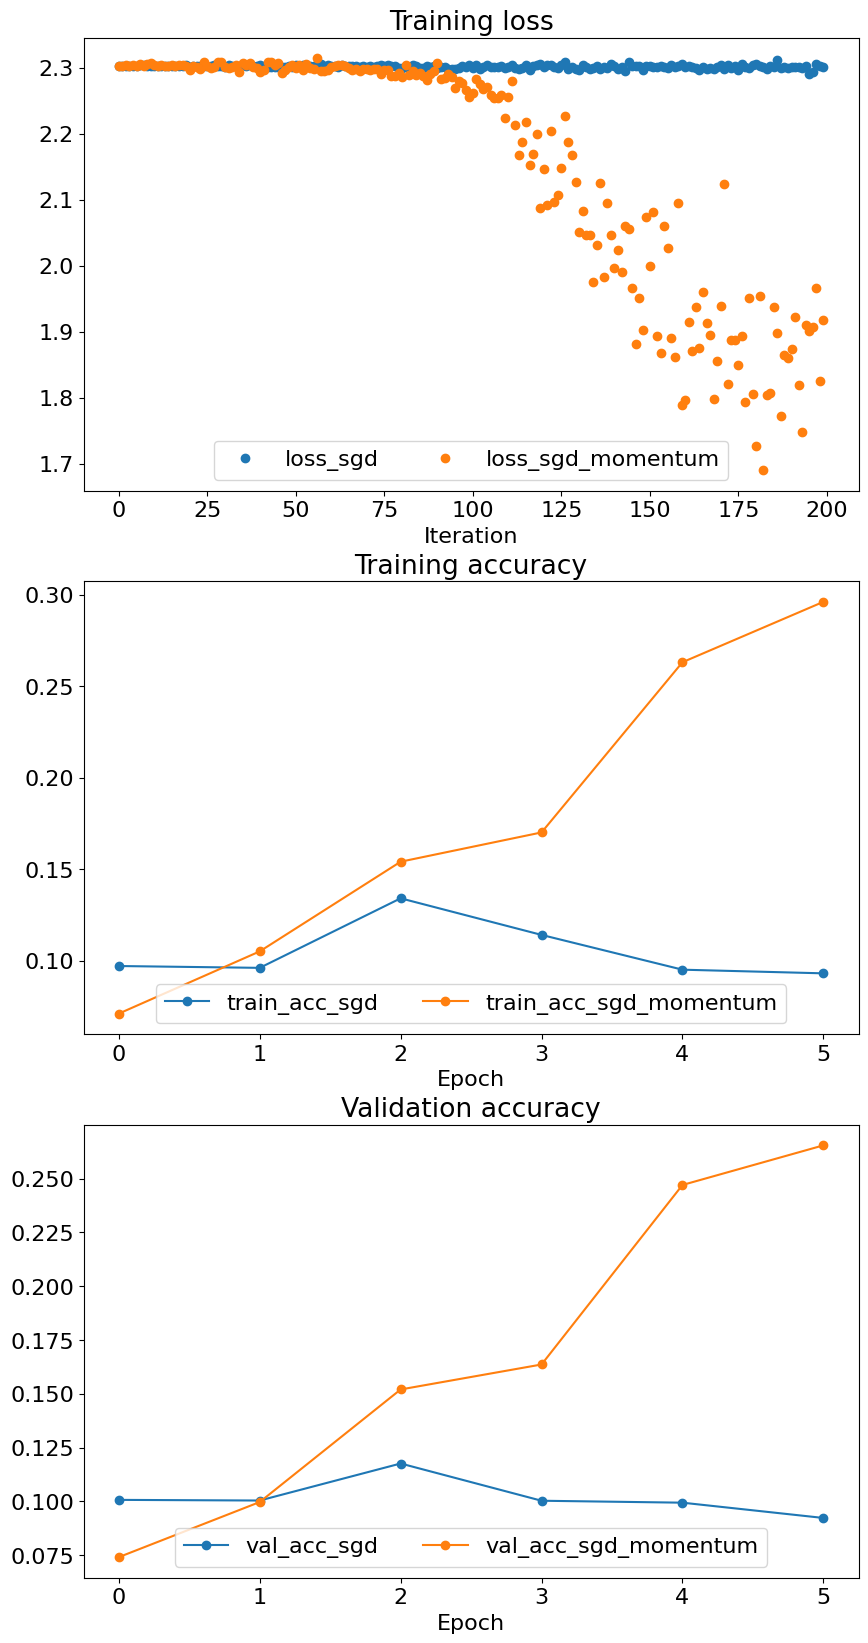

In [ ]:
from fully_connected_networks import FullyConnectedNet, sgd, sgd_momentum


reset_seed(0)

num_train = 4000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}

for update_rule_name, update_rule_fn in [('sgd', sgd), ('sgd_momentum', sgd_momentum)]:
  print('running with ', update_rule_name)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,
                            dtype=torch.float32, device=device)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': 5e-2,
                  },
                  print_every=1000,
                  verbose=True,
                  device=device)
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in solvers.items():
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)


plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

## RMSProp
RMSProp is an update rule that set per-parameter learning rates by using a running average of the second moments of gradients.

**Implement** the RMSProp update rule in the `rmsprop` function in `fully_connected_networks.py`. Run the following to test your RMSProp implementation. You should see errors less than `1e-6`.

In [ ]:
from fully_connected_networks import rmsprop

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)
cache = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]],
   dtype=torch.float64, device=device)
expected_cache = torch.tensor([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]],
   dtype=torch.float64, device=device)

print('next_w error: ', libs.grad.rel_error(expected_next_w, next_w))
print('cache error: ', libs.grad.rel_error(expected_cache, config['cache']))

next_w error:  4.064797880829826e-09
cache error:  1.8620321382570356e-09


## Adam
Adam extends RMSprop with a first-order gradient cache similar to momentum, and a bias correction mechanism to prevent large steps at the start of optimization. Adam is one of the most commonly used update rules used in practice for training deep neural networks.

Implement the Adam update rule in the `adam` function in `fully_connected_networks.py`. Run the following to test your Adam implementation. You should see error less than `1e-6` for `next_w`, and errors less than `1e-8` for `v` and `m`:



**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism).

In [ ]:
from fully_connected_networks import adam

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)
m = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)
v = torch.linspace(0.7, 0.5, steps=N*D, dtype=torch.float64, device=device).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]],
   dtype=torch.float64, device=device)
expected_v = torch.tensor([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]],
   dtype=torch.float64, device=device)
expected_m = torch.tensor([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]],
   dtype=torch.float64, device=device)

# You should see relative errors around e-7 or less
print('next_w error: ', libs.grad.rel_error(expected_next_w, next_w))
print('v error: ', libs.grad.rel_error(expected_v, config['v']))
print('m error: ', libs.grad.rel_error(expected_m, config['m']))

next_w error:  3.756728297598868e-09
v error:  3.4048987160545265e-09
m error:  2.786377729853651e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  sgd_momentum
(Time 0.02 sec; Iteration 1 / 200) loss: 2.302626
(Epoch 0 / 5) train acc: 0.154000; val_acc: 0.147100
(Epoch 1 / 5) train acc: 0.281000; val_acc: 0.247900
(Epoch 2 / 5) train acc: 0.293000; val_acc: 0.287400
(Epoch 3 / 5) train acc: 0.363000; val_acc: 0.326300
(Epoch 4 / 5) train acc: 0.402000; val_acc: 0.343700
(Epoch 5 / 5) train acc: 0.459000; val_acc: 0.351500

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302484
(Epoch 0 / 5) train acc: 0.129000; val_acc: 0.132400
(Epoch 1 / 5) train acc: 0.238000; val_acc: 0.210000
(Epoch 2 / 5) train acc: 0.272000; val_acc: 0.254600
(Epoch 3 / 5) train acc: 0.274000; val_acc: 0.259100
(Epoch 4 / 5) train acc: 0.274000; val_acc: 0.261600
(Epoch 5 / 5) train acc: 0.305000; val_acc: 0.264800



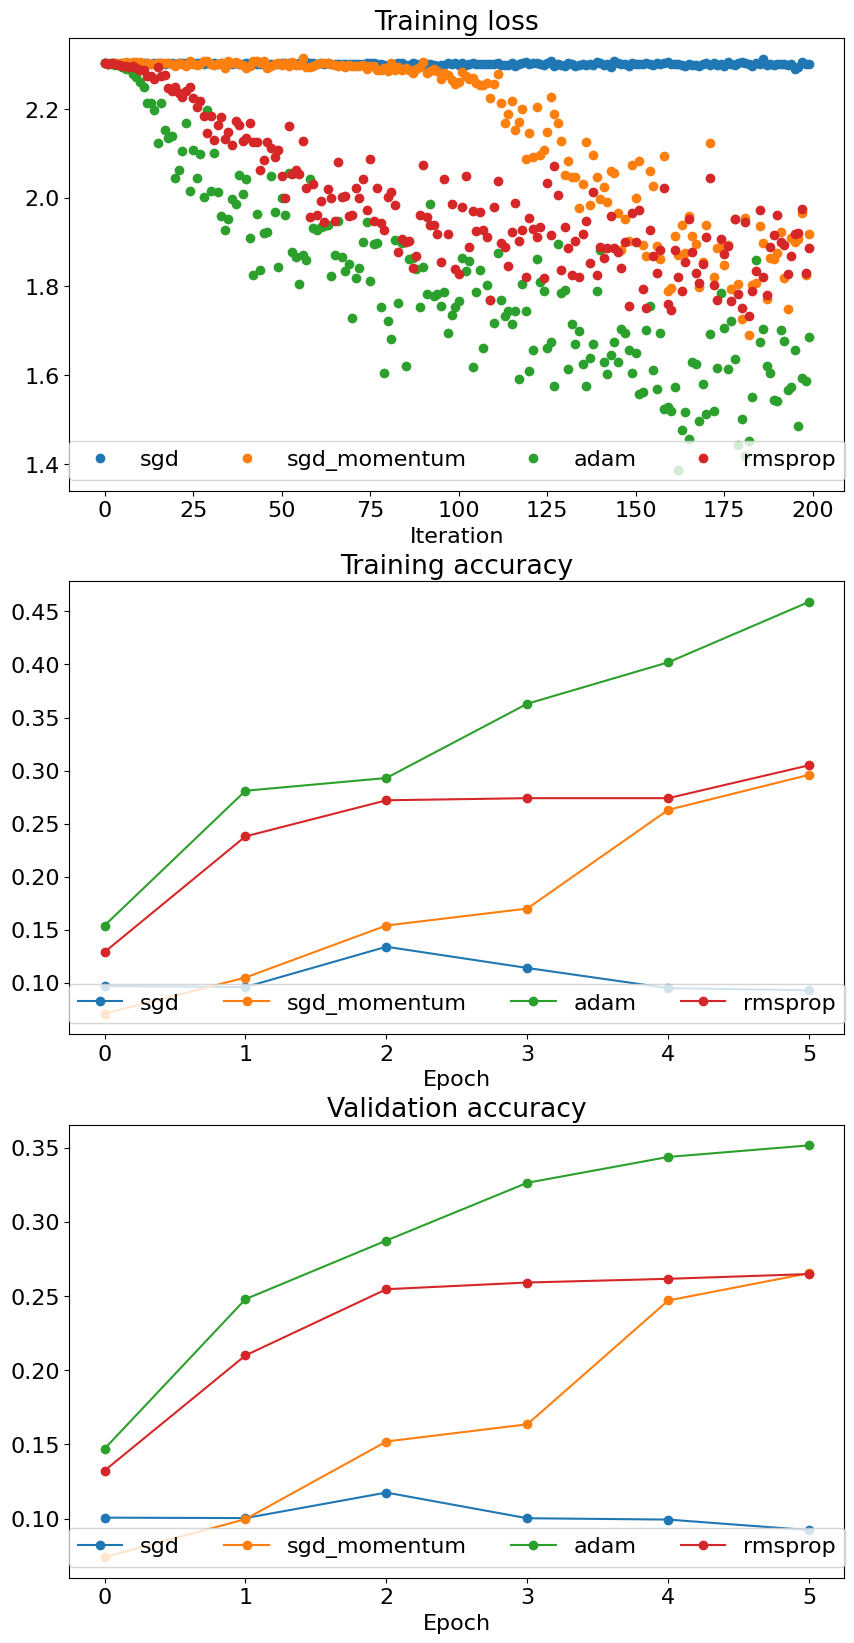

In [ ]:
from fully_connected_networks import adam, rmsprop, FullyConnectedNet

for update_rule_name, update_rule_fn, learning_rate in [('adam', adam, 1e-3), ('rmsprop', rmsprop, 1e-4)]:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, device=device)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=1000,
                  verbose=True, device=device)
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.loss_history, 'o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.train_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

# Dropout (Bonus)
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

## Dropout: forward
**Implement** the forward pass for dropout in `fully_connected_networks.py`. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Run the following to test your dropout implementation. The mean of the output should be approximately the same during training and testing. During training the number of outputs set to zero should be approximately equal to the drop probability `p`, and during testing no outputs should be set to zero.

In [ ]:
from fully_connected_networks import Dropout

reset_seed(0)
x = torch.randn(500, 500, dtype=torch.float64, device=device) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = Dropout.forward(x, {'mode': 'train', 'p': p})
  out_test, _ = Dropout.forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean().item())
  print('Mean of train-time output: ', out.mean().item())
  print('Mean of test-time output: ', out_test.mean().item())
  print('Fraction of train-time output set to zero: ', (out == 0).type(torch.float32).mean().item())
  print('Fraction of test-time output set to zero: ', (out_test == 0).type(torch.float32).mean().item())
  print()

## Dropout: backward
Implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [ ]:
from fully_connected_networks import Dropout

reset_seed(0)
x = torch.randn(10, 10, dtype=torch.float64, device=device) + 10
dout = torch.randn_like(x)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 0}
out, cache = Dropout.forward(x, dropout_param)
dx = Dropout.backward(dout, cache)
dx_num = libs.grad.compute_numeric_gradient(lambda xx: Dropout.forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', libs.grad.rel_error(dx, dx_num))

# Fully-connected nets with dropout (Bonus)
Modify your implementation of `FullyConnectedNet` to use dropout. Specifically, if the constructor of the network receives a value that is not 0 for the `dropout` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity.

After doing so, run the following to numerically gradient-check your implementation. You should see errors less than `1e-5`, and different dropout rates should result different error values.

In [ ]:
from fully_connected_networks import FullyConnectedNet

reset_seed(0)

N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, dtype=torch.float64, device=device)
y = torch.randint(C, size=(N,), dtype=torch.int64, device=device)

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dropout=dropout,
                            seed=0, dtype=torch.float64, device=device)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  # Relative errors should be around e-5 or less.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = libs.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, libs.grad.rel_error(grad_num, grads[name])))
  print()

## Regularization experiment
To get a sense of the way that dropout can regularize a neural network, we will train three different two-layer networks:

1. Hidden size 256, dropout = 0
2. Hidden size 512, dropout = 0
3. Hidden size 512, dropout = 0.5

We will then visualize the training and validation accuracies of these three networks.

In [ ]:
from fully_connected_networks import FullyConnectedNet

# Train two identical nets, one with dropout and one without
reset_seed(0)
num_train = 20000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}
dropout_choices = [0, 0, 0.5]
width_choices = [256, 512, 512]
for dropout, width in zip(dropout_choices, width_choices):
# for dropout in dropout_choices:
  model = FullyConnectedNet([width], dropout=dropout, dtype=torch.float32, device=device)
  print('Training a model with dropout=%.2f and width=%d' % (dropout, width))

  solver = Solver(model, small_data,
                  num_epochs=100, batch_size=512,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  print_every=100000, print_acc_every=10,
                  verbose=True, device=device)
  solver.train()
  solvers[(dropout, width)] = solver
  print()

If everything worked as expected, you should see that the network with dropout has lower training accuracies than the networks without dropout, but that it achieves higher validation accuracies.

You should also see that a network with width 512 and dropout 0.5 achieves higher validation accuracies than a network with width 256 and no dropout. This demonstrates that reducing the model size is not generally an effective regularization strategy -- it's often better to use a larger model with explicit regularization.

In [ ]:
plt.subplot(2, 1, 1)
for (dropout, width), solver in solvers.items():
  train_acc = solver.train_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(train_acc, 'o', label=label)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(2, 1, 2)
for (dropout, width), solver in solvers.items():
  val_acc = solver.val_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(val_acc, 'o', label=label)
plt.ylim(0.4, 0.52)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 15)
plt.show()